---
## Traffic sign classifier using Convolutional Neural Network

this is aframework which can be used to classify images . in this program i had classified the german trafic sign images . using my model , i was able to classify some random images which i downloaded from online 

### loading datas
load the training , validation , and testing data to work with your model

###### please specify the correct file path in the training_file ,validation_file and testing_file


In [1]:
# Load pickled data
import pickle
import tensorflow as tf

training_file ='data\\train.p' 
validation_file='data\\valid.p'
testing_file = 'data\\test.p'


with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test = test['features'], test['labels']

### sign name 
the labels in the training data uses specific numbers to identify different signs . the filesignnames.csv has the number mapped for the sign type . this code  block is goingto create a dictionary of numbers to the sign type . this will come in handy when we classify our own images taken from internet

In [2]:
# create a dictionary with class number and sign name pair
import csv
signValues = {}
with open('signnames.csv',newline='') as file :
    read = csv.reader(file,delimiter = ',', quotechar='|')
    for row in read:
        if row[0] != 'ClassId':
            signValues[int(row[0])] = row[1]

In [3]:
EPOCHS = 10
BATCH_SIZE = 128

### summery of our data

In [4]:

import numpy as np

n_train = X_train.shape[:][0]


n_test =  y_test.shape[:][0]


image_shape = X_train[0].shape

n_classes = np.max(y_train)

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 42


### visualizaton of training data 

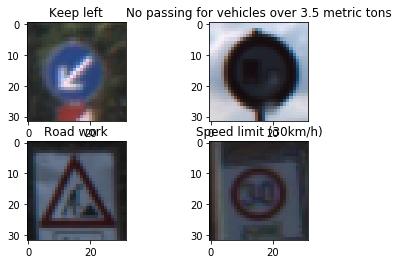

In [5]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.
import matplotlib.pyplot as plt
import random
# Visualizations will be shown in the notebook.
%matplotlib inline
#http://matplotlib.org/examples/pylab_examples/subplots_demo.html



#plt.set_window_title('hi')
_,a = plt.subplots(2,2)
if X_train[0].shape[2] == 3: # to check whether the image formate is BGR (or) grayscale
    for i in range(0,2):
        for j in range(0,2):

            w = random.randint(0,X_train.shape[:][0])
            a[i][j].imshow( X_train[w])
            a[i][j].set_title(signValues[y_train[w]])

    plt.show()
else :
    print ('training datas has been converted to gray scale image ')



### preprocess and augment the training data

our training data is made up of 32X3X3 (BGR) . training on this data is one way of approach
but , if we convert it into grayscale image of 32X32X1 , the training process will be much easy 

normalization of the image will refine the sign details by removing the background noices which 
will help in trining process 
the code block below will convert the train , test and validation data to grayscale nad normalizze it by 128
(x-128)/128

Augmentation is the process of applying transformation rotation to the training data and adding them to the 
training data which will increase the number of training data 

In [6]:

%matplotlib inline
import cv2

k = []
l = []
# width and height of the imput image 
width = X_train.shape[1] 
col = X_train.shape[2]

for i in range(X_train.shape[:][0]):
    temp = cv2.cvtColor(X_train[i], cv2.COLOR_BGR2GRAY) # convert BGR to grayscale image
    temp = (temp-128)/128#  normalization of image
    k.append(np.reshape(temp,(32,32,1))) #reshaping temp image of size 32X32 to 32X32X1
    l.append(y_train[i])

# create 10000 additional training data by transforming training  data  
v = 0

while v < 10000:
    v+=1
        
    
    rand = random.randint(0,X_train.shape[0]-1) # generate a random varable to choose an image 
    img = X_train[rand]
    w,h = random.randint(0,5),random.randint(0,5)# generate a random varable to shift the image by pixels
    M = np.float32([[1,0,w],[0,1,h]])
        
    opt = cv2.warpAffine(img,M,(col,width))
    opt = cv2.cvtColor(opt, cv2.COLOR_BGR2GRAY)
    opt = (opt-128)/128 #  normalization of image
    k.append(np.reshape(opt,(32,32,1)))
    l.append(y_train[rand]) # grab and add the training label for the specific trafic sign

  
    
X_train = np.array(k)
y_train = np.array(l)
print (X_train.shape)

xTest = []
# test image grayscale conversion and normalization
for i in range(X_test.shape[:][0]):
    temp = cv2.cvtColor(X_test[i], cv2.COLOR_BGR2GRAY)
    temp = (temp-128)/128#  normalization of image
    xTest.append(np.reshape(temp,(32,32,1)))
X_test = np.array(xTest)
print (X_test.shape)

# validation image grayscale conversion and normalization
xValid = []
for i in range(X_valid.shape[:][0]):
    temp = cv2.cvtColor(X_valid[i], cv2.COLOR_BGR2GRAY)
    temp = (temp-128)/128#  normalization of image
    xValid.append(np.reshape(temp,(32,32,1)))
X_valid = np.array(xValid)
print (X_valid.shape)


(44799, 32, 32, 1)
(12630, 32, 32, 1)
(4410, 32, 32, 1)


### shuffling of data

In [7]:
from sklearn.utils import shuffle

X_train, y_train = shuffle(X_train, y_train)
X_test, y_test = shuffle(X_test, y_test)
X_valid, y_valid = shuffle(X_valid, y_valid)

### visualization of the normalized image

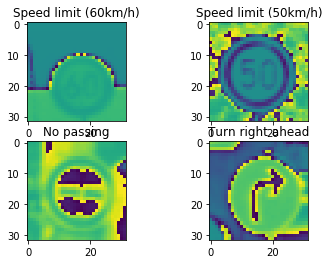

In [8]:

import matplotlib.pyplot as plt
import random

%matplotlib inline




#plt.set_window_title('hi')
_,a = plt.subplots(2,2)

for i in range(0,2):
    for j in range(0,2):
        
        w = random.randint(0,X_train.shape[0])
        a[i][j].imshow( X_train[w].squeeze())
        a[i][j].set_title(signValues[y_train[w]])
        
plt.show()




### Model Architecture

### function to create convolution layer 

conv2d ( input (Tf placeholder) , filter (Weights) , stride size , padding ('VALID','SAME') , biase  )

this function takes input (tf constant , image , convolute layer ) , weights , and biase , create convolute layer
using provided weight , adds biases to it and applies relu 

In [9]:
def conv2d(input,filter,strides,padding,biase):
    #creation of a convolution layer
    convLayer = tf.nn.conv2d(input,filter,strides,padding)
    convLayer = tf.nn.bias_add(convLayer,biase)
    convLayer = tf.nn.relu(convLayer)
    return convLayer

### function to apply pooling to the convolute layer 

pooling ( input (convolute layer) , ksize (window ) , stride , padding('VOID ' , 'SAME))

In [10]:
def pooling(input , ksize , strides , padding):
    maxPool = tf.nn.max_pool(input , ksize , strides , padding)# applying max pooling to the convolute lyer
    return maxPool
    

In [11]:
# definition of mean and standerd deviation for truncated normal
mu = 0
sigma = 0.01

### Define placeholder

In [12]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))# image placeholder for grayscale image with dimention (None ,32,32,1)
y = tf.placeholder(tf.int32, (None))# image label placeholder
one_hot_y = tf.one_hot(y, 42)# label converted to oh hot encoding for easy classification by neurons in output layer
dropout = tf.placeholder(tf.float32,(None))# dropout place holder ( 0.0 - 1.0)

### Weights and Biase variable definition 

#### for convolution layer

In [13]:
# definition of weights 
import tensorflow as tf
weights1 = {'wc1':tf.Variable(tf.truncated_normal([5,5,1,6],mean = mu , stddev = sigma)),# [height , width , ip_dimention , op_dimention]
           'wc2':tf.Variable(tf.truncated_normal([2,2,6,16],mean = mu , stddev = sigma)),
           'wc3':tf.Variable(tf.truncated_normal([3,3,16,32],mean = mu , stddev = sigma))}
biases1  = {'bc1':tf.Variable(tf.truncated_normal([6],mean = mu , stddev = sigma)),
           'bc2':tf.Variable(tf.truncated_normal([16],mean = mu , stddev = sigma)),
           'bc3':tf.Variable(tf.truncated_normal([32],mean = mu , stddev = sigma))}

#### for fully connected layer

In [14]:
# defining weights and biases for fully connected layer
weightFullyConnected1 = {'wf1':tf.Variable(tf.truncated_normal([2304,1024],mean = mu , stddev = sigma)),
                        'wf2':tf.Variable(tf.truncated_normal([1024,512],mean = mu , stddev = sigma)),
                        'wf3':tf.Variable(tf.truncated_normal([512,256],mean = mu , stddev = sigma)),
                        'out':tf.Variable(tf.truncated_normal([512,42],mean = mu , stddev = sigma))}
biasesFullyConnected1 = {'bf1':tf.Variable(tf.truncated_normal([1024],mean = mu , stddev = sigma)),#120 - 320
                        'bf2':tf.Variable(tf.truncated_normal([512],mean = mu , stddev = sigma)),
                        'bf3':tf.Variable(tf.truncated_normal([256],mean = mu , stddev = sigma)),
                        'out':tf.Variable(tf.truncated_normal([42],mean = mu , stddev = sigma))}

### Graph definition 

In [35]:

from tensorflow.contrib.layers import flatten

def graph(x):    
    layer1 = conv2d(x,weights1['wc1'],[1,1,1,1],'VALID',biases1['bc1']) # (32,32,3) -> (28,28,6)
    layer1 = pooling(layer1,[1,5,5,1],[1,1,1,1],'VALID')# (28,28,6) -> (24,24,6)

    layer2 = conv2d(layer1,weights1['wc2'],[1,2,2,1],'VALID',biases1['bc2'])# (24,24,6) -> (12,12,16)

    layer3 = conv2d(layer2,weights1['wc3'],[1,1,1,1],'VALID',biases1['bc3'])#(12,12,16) -> (10,10,32)

    layer3 = pooling(layer3,[1,2,2,1],[1,2,2,1],'VALID')# (10,10,32) -> (5,5,32)


    # adding flatten to 
    flatInput = flatten(layer2) #(5,5,32) -> (2304)

    fc1 = tf.add(tf.matmul(flatInput,weightFullyConnected1['wf1']),biasesFullyConnected1['bf1'])
    fc1 = tf.nn.relu(fc1) # (2304) -> (1024)

    fc2 = tf.add(tf.matmul(fc1,weightFullyConnected1['wf2']),biasesFullyConnected1['bf2'])
    fc2 = tf.nn.relu(fc2)
    fc2 = tf.nn.dropout(fc2,dropout) # (1024) -> (512)
    
    
    out = tf.add(tf.matmul(fc2,weightFullyConnected1['out']),biasesFullyConnected1['out'])# (512) -> (42)
    
    return out


### To visualize the model
To visualize the features of eaxh layers , we have to pass the data through the seperately . defining them here will
help us to vizualize those features (to see visualization , go down )

In [53]:
layer1 = conv2d(x,weights1['wc1'],[1,1,1,1],'VALID',biases1['bc1'])
layer1pool = pooling(layer1,[1,5,5,1],[1,1,1,1],'VALID')

layer2 = conv2d(layer1pool,weights1['wc2'],[1,2,2,1],'VALID',biases1['bc2'])

layer3 = conv2d(layer2,weights1['wc3'],[1,1,1,1],'VALID',biases1['bc3'])

layer3pool = pooling(layer3,[1,2,2,1],[1,2,2,1],'VALID')


### Initialization of methods 

In [36]:
rate = 0.0005

logits = graph(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = one_hot_y)#one_hot_y :y
just_soft_max = tf.nn.softmax(logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)

training_operation = optimizer.minimize(loss_operation)

In [37]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))#one_hot_y :y
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
predictions = tf.argmax(logits, 1)
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y,dropout : 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [38]:
model = 'model\\data'

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [52]:
from sklearn.utils import shuffle
import time
start_time = time.time()
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            
        
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y,dropout:0.8})
            
        validation_accuracy = evaluate(X_valid, y_valid)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print ('time for epoch {} is {}'.format(i,start_time - time.time()))
        print()
        
    saver.save(sess, model)
    print("Model saved")
    print ('total time {}'.format(time.time()-start_time))
    
    
    

Training...

EPOCH 1 ...
Validation Accuracy = 0.059
time for epoch 0 is -137.3748495578766

EPOCH 2 ...
Validation Accuracy = 0.207
time for epoch 1 is -280.61756896972656

EPOCH 3 ...
Validation Accuracy = 0.361
time for epoch 2 is -411.74989223480225

EPOCH 4 ...
Validation Accuracy = 0.498
time for epoch 3 is -556.5656604766846

EPOCH 5 ...
Validation Accuracy = 0.571
time for epoch 4 is -757.591477394104

EPOCH 6 ...
Validation Accuracy = 0.595
time for epoch 5 is -944.9020855426788

EPOCH 7 ...
Validation Accuracy = 0.647
time for epoch 6 is -1139.8047077655792

EPOCH 8 ...
Validation Accuracy = 0.664
time for epoch 7 is -1328.4365124702454

EPOCH 9 ...
Validation Accuracy = 0.678
time for epoch 8 is -1502.579677581787

EPOCH 10 ...
Validation Accuracy = 0.659
time for epoch 9 is -1703.6892035007477

Model saved
total time 1714.0775396823883


### Testing your model

In [42]:
with tf.Session() as sess:
    saver.restore(sess, model)
    testAccuracy = evaluate(X_test,y_test)
    print ('the test accuracy of this model : {}'.format(testAccuracy))

the test accuracy of this model : 0.6278701505864884


### Load New Image 

this code block loads new image downloaded from online , reshapes them into 32X32X3 , converts it to grayscape and applies normalization , and add it to X_out with shape (None , 32 , 32 , 1)

In [43]:
import os
fileName = ['testPic\\'+name for name in os.listdir('testPic')] # file name which has the images
outTest = []
for name in fileName:
    test = cv2.imread(name,1)
    
    test = cv2.resize(test,(32,32),interpolation = cv2.INTER_AREA) # resize the image of any size to (32X32)
    temp = cv2.cvtColor(test, cv2.COLOR_BGR2GRAY)# convert to grayscale image
    temp = (temp-128)/128# apply normalization 

    outTest.append(np.reshape(temp,(32,32,1)))# add depth to image 
X_out = np.array(outTest)
print (X_out.shape)

(5, 32, 32, 1)


### Predict the Sign Type for Each Image 

In [54]:

with tf.Session() as sess:
    saver.restore(sess, model)
    pri = sess.run(predictions,feed_dict={x:X_out,dropout:1.0}) # predict the label for these images . use 1.0 for dropout value

predictedSign = [signValues[x] for x in pri]
print (predictedSign)

['Speed limit (30km/h)', 'Speed limit (60km/h)', 'Road work', 'Wild animals crossing', 'Roundabout mandatory']


### Analyze Performance

In [55]:
hand_coded_labels = [1,3,11,31,33] # hand code the sign h=number using the signname.csv file provided 
count = 0
for i in range(len(pri)):
    if pri[i]== hand_coded_labels[i]: # check with the predicted result
      count+=1
percentage = (100/len(pri))*count # calculate the accuracy of your prediction 
print ('This is the percentage of accuracy for this test model {}%'.format(percentage))

This is the percentage of accuracy for this test model 60.0%


### Display the top softmax predictions for our own image 

In [25]:
# printing the top 3 softmax prediction on the image taken from online
with tf.Session() as sess:
    saver.restore(sess, model)
    softmaxValue = sess.run(tf.nn.top_k(just_soft_max,k=3),feed_dict={x:X_out,dropout:1.0})
   

index = softmaxValue[1]
softmax = softmaxValue[0]
for i in range (len(index)) :
    print_index = index[i]
    print_soft = softmax[i]
    value = ''
    for j in range(len(print_index)):
        value += signValues[print_index[j]]
        value += ' = '+str(print_soft[j]) 
        value +='\n'
    print (value)
 

Speed limit (30km/h) = 0.542862
Speed limit (20km/h) = 0.210906
Speed limit (50km/h) = 0.157635

Speed limit (60km/h) = 0.76604
Speed limit (30km/h) = 0.148891
Speed limit (80km/h) = 0.0791803

Children crossing = 0.735759
Right-of-way at the next intersection = 0.1928
Road work = 0.0456295

Wild animals crossing = 0.986611
Double curve = 0.0120036
Dangerous curve to the left = 0.000717828

Roundabout mandatory = 0.488365
Speed limit (20km/h) = 0.207788
Speed limit (30km/h) = 0.175993



---

##  Visualization of  the Neural Network's State with Test Images

 


In [48]:
def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input,dropout:1.0})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

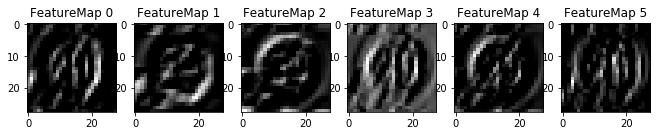

In [59]:
### to visualize the feature map 
with tf.Session() as sess:
    saver.restore(sess, model)
    outputFeatureMap(X_out[0:1], layer1 , activation_min=-1, activation_max=-1 ,plt_num=1)
    

### use of visualizing feature map 

visualization of feature map , clearly shows us the type of features which causes activation on our convalution layer 

the lighter pixels in the images , shows the  feature which causes activation , where the darker pixels represent no 
activation 

comparing these images with the original image , shows us a clear understanding of what casing activation 